# Grouping conceptually similar (Finnish) words 

This is a brief test on how to group together words that share some conceptual connection. The test utilizes SOM maps and word embeddings to achieve to desired result.

The data consists of Finnish sentences associated with some aspects. For example:

**Sentence**: "Tuote X on liian suolaista ja hintakin on liian kova."  **Aspects**: "maku, hinta"  
**In English**: "Product X is too salty and the price is also too high." **Aspects**: "taste, price"

The dataset in question is not publicly available, but the effectiveness of the method can be evaluated by inspecting the visualized map at the end of this notebook.

# 1. Initial tasks

In [1]:
import libvoikko
import math
import numpy as np
import pandas as pd
import pickle

from gensim.models.keyedvectors import KeyedVectors
from matplotlib import pyplot as plt
from minisom import MiniSom
from pathlib import Path

Read the data, keep only the aspects:

In [2]:
df = pd.read_csv('data.tsv', sep='\t', keep_default_na=False,
                 names=['1', '2', 'initial', '3', '4', '5'])[['initial']]

The aspects are just ordinary Finnish words:

In [3]:
df.head()

initial
0                                 status
1                       auto,merkki,ääni
2                         hinta,piirteet
3  bensankulutus,kestävyys,kulutus,laatu
4                              ikä,malli

Notice that the sentences have annotated by several annotators so a single line might contain a single aspect multiple times.

We first perform some initial housekeeping:
* replace invalid aspect separator (spaces) with proper separators (commas)
* replace chars '/' with '-'
* drop aspects of length 1 as they are considered to be beyond any rectification
* all aspects are spell-checked and lemmatized

**libvoikko** is used for spell-checking and lemmatization:

In [4]:
class Voikko:
    def __init__(self):
        self._voikko = libvoikko.Voikko(u"fi")
        
    def as_baseform(self, aspect):
        """ A lemmatized version of the aspect """
        try:
            return self._voikko.analyze(aspect)[0]['BASEFORM']
        except IndexError:
            return aspect
        
    def suggest(self, aspect):
        """ Spell-checked form of the aspect """
        try:
            return self._voikko.suggest(aspect)[0]
        except IndexError:
            return aspect
        
    def transform(self, aspect):
        return self.as_baseform(self.suggest(aspect))

voikko = Voikko()

In [5]:
def rectify_aspects(aspects):
    tmp = aspects.replace(' ', ',').replace('/', '-').split(',')
    return ','.join([voikko.transform(a) for a in tmp if len(a) > 1])
df['rectified'] = df['initial'].apply(rectify_aspects)

Here are the initial and rectified aspects: 

In [6]:
for _, row in df.iterrows():
    if row['initial'] != row['rectified']:
        print("Initial:", row['initial'][:50].ljust(50, ' ') ,
              "...  " if len(row['initial']) > 50 else '     ',
              "Rectified:", row['rectified'][:50].ljust(50, ' '),
              "..." if len(row['rectified']) > 50 else '')

Initial: hinta,piirteet                                           Rectified: hinta,piirre                                       
Initial: kysymys,ominaisuudet,tietokone                           Rectified: kysymys,ominaisuus,tietokone                       
Initial: apple,laatu,laatu,laatu,laatu,tuntuma,yleiskuva          Rectified: Apple,laatu,laatu,laatu,laatu,tuntuma,yleiskuva    
Initial: pelaaminen,pelaaminen,pelaaminen,tehokkuus               Rectified: pelata,pelata,pelata,tehokkuus                     
Initial: laatu,levy,ominaisuus,vuosi,yksinkertaisuus,ääni         Rectified: laatu,levy,ominaisuus,vuotaa,yksinkertaisuus,ääni  
Initial: perusteet                                                Rectified: peruste                                            
Initial: mestaruus,sarja,taito,taso,vitsi,voitt                   Rectified: mestaruus,sarja,taito,taso,vitsi,voida             
Initial: arvot,luotettavuus,puolueettomuus                        Rectified: arpoa,luotettavuus,p

The results are somewhat ambivalent. For example many spelling errors such as _"uuttuus"_ have been properly corrected as _"uutuus"_, but on the other hand there are also some questionable corrections. Of course, in some cases such as with an initial aspect _"laa"_ it is difficult even for a human observer to determine what was the actual intended aspect.

For grouping synonyms and conceptually closely related aspects every aspect is first associated with a _Word2Vec_ embedding (using a model kindly provided by TurkuNLP at https://turkunlp.org/finnish_nlp.html#parsebank). A word embedding is a machine-learned representation of the word as an N-dimensional (in this case N = 200) vector, the values of which depend on the context in which the word typically appears.

In [7]:
embeddings_file = Path('./aspect_embeddings.p')
if embeddings_file.is_file():
    aspect_embeddings = pickle.load(open(embeddings_file, 'rb'))
else:
    embeddings_model_file = '~/Documents/Word2Vec/finnish_s24_skgram.bin'
    w2v = KeyedVectors.load_word2vec_format(embeddings_model_file,
                                            binary=True,
                                            unicode_errors='ignore')
    aspect_embeddings = {}
    for _, row in df.iterrows():
        for aspect in row['rectified'].split(','):
            if aspect not in aspect_embeddings:
                try:
                    aspect_embeddings[aspect] = w2v[aspect]
                except KeyError:
                    pass  # skip an aspect that does not have an embedding
    pickle.dump(aspect_embeddings, open(embeddings_file, 'wb'))

To generate the actual aspect grouping these embeddings are then passed on to a self-organizing map (SOM). The implementation used here is _MiniSom_ (see https://github.com/JustGlowing/minisom). Put briefly, SOMs are a method of unsupervised competitive learning partially reminiscent of K-Means. It essentially performs a dimensionality reduction on the input data and represents the ultimate distribution as a map.

In [8]:
num_words = len(aspect_embeddings)
som_file = Path('./aspect_som.p')
if som_file.is_file():
    # load the som if it was previously written on disk 
    som_map = pickle.load(open(som_file, 'rb'))
else:
    # instantiate som with a num_words x num_words sized grid, vector length 200
    # we use a small sigma value to to keep the word neighborhood radius small 
    som = MiniSom(num_words, num_words, 200, sigma=0.01, learning_rate=1.5)
    aspect_vecs = np.empty((0,200))
    aspect_labels = []
    for aspect, embedding in aspect_embeddings.items():
        aspect_vecs = np.vstack((aspect_vecs, embedding))
        aspect_labels.append(aspect)
    # train by picking samples at random
    som.train_random(aspect_vecs, 1000, verbose=True)
    som_map = som.labels_map(aspect_vecs, aspect_labels)
    pickle.dump(som_map, open(som_file, 'wb'))

Let's plot some groups to see if there's any sense to the generated mapping.

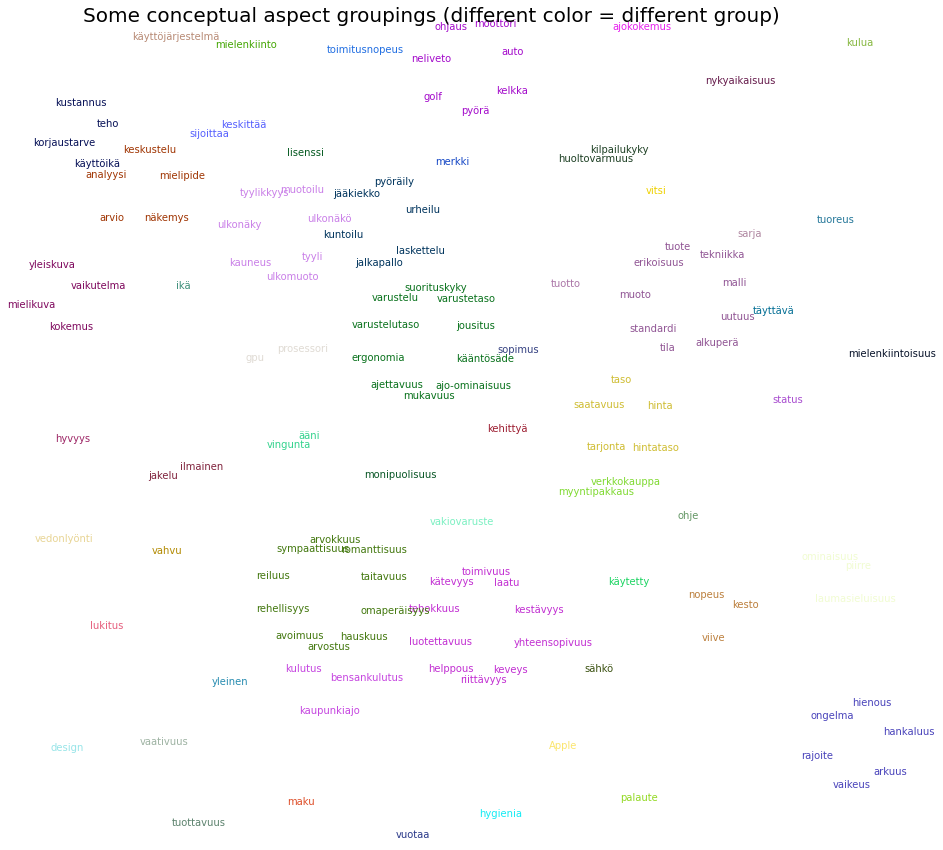

In [9]:
def get_coords(num, coords, divisor):
    """ 
    Generates coordinates for each aspect in a group. The words are arranged 
    in an approximately circular fashion around the center point.
    """
    # scale coordinates to [0, 1]
    orig_x = coords[0] / divisor  
    orig_y = coords[1] / divisor
    # radius of the circle
    radius = math.log(num) / 35 
    # angle separating the aspects
    angle_step = 360 / num
    current = 0
    while current < num:
        angle = math.radians(angle_step * current) + 0.3  # offset to reduce overlap
        x = orig_x + radius * math.cos(angle)
        y = orig_y + radius * math.sin(angle)
        current += 1
        yield x, y

def too_close(coords, previous_coords):
    """ Is this group too close (in a coordinate sense) to previous groups """
    for p in previous_coords:
        if math.sqrt((coords[0] - p[0]) ** 2 + (coords[1] - p[1]) ** 2) < 40:
            return True
    return False
        
plt.figure(figsize=(15, 15))
ax = plt.axes(frameon=False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# groups with most aspects first
sorted_map = sorted([[k, v] for k, v in som_map.items()],
                    key=lambda x: len(x[1]),
                    reverse=True)

previous_coords = []
for coords, aspects_counter in som_map.items():
    aspects = [k for k in aspects_counter][:10]
    color = np.random.rand(3,)
    if not too_close(coords, previous_coords):
        for (x, y), a in zip(get_coords(len(aspects), coords, num_words), aspects):
            plt.text(x, y, a, c=color)
        previous_coords.append(coords)
plt.title('Some conceptual aspect groupings (different color = different group)',
          fontsize=20)
plt.show()

As can be seen there are definitely some very coherent groups, e.g. _{pyöräily, jääkiekko, urheilu, kuntoilu, laskettelu, jalkapallo}_ and then there some that are mostly reasonable but with some flaws, e.g. _{ongelma, rajoite, vaikeus, arkuus, hankaluus, **hienous**}_. These groupings can be further adjusted by tuning the parameters of the SOM process. For example, increasing the number of the training cycles tends to produce more groups with less members.